In [1]:
print('what\'s up?')

what's up?


# NOTEBOOK IMPORTS

In [234]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

%matplotlib inline

# CONSTANTS

In [251]:
EXAMPLE_FILE='SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE=2500

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

# READING FILES

In [7]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
message= stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [6]:
import sys 
sys.getfilesystemencoding()

'utf-8'

In [150]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [9]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [10]:
for i in generate_squares(5):
    print(i,end='->')

0->1->4->9->16->

## Email body extraction

In [151]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [152]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [153]:
spam_emails= df_from_directory(SPAM_1_PATH,1)
spam_emails= spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [145]:
spam_emails

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...
01397.f75f0dd0dd923faefa3e9cc5ecb8c906,This is a multi-part message in MIME format.\n...,1
01398.8ca7045aae4184d56e8509dc5ad6d979,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1
01399.2319643317e2c5193d574e40a71809c2,****Mid-Summer Customer Appreciation SALE!****...,1
01400.b444b69845db2fa0a4693ca04e6ac5c5,ATTN:SIR/MADAN \n\n\n\n ...,1


In [25]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.shape

(3901, 2)

In [27]:
data= pd.concat([spam_emails,ham_emails])
print('shape of entire data_set is = ', data.shape)
data.head()

shape of entire data_set is =  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [28]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


## DATA CLEANING: CHECK FOR MISSING VALUES

In [31]:
#check if any message body is null
data['MESSAGE'].isnull().values.any() #tells if any of the email is null 

False

In [32]:
type('')

str

In [33]:
len('')

0

In [34]:
my_var=None

In [35]:
#check if any of the emails are empty
(data.MESSAGE.str.len()==0).any()

True

In [38]:
(data.MESSAGE.str.len()==0).sum() #HOW MANY OF THESE EMIALS ARE EMPTY

3

# lOCATE EMPTY EMAILS

In [39]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [40]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# DROPPING UNDESIRED EMAILS

In [41]:
data.drop(['cmds'],inplace=True)

In [42]:
data.shape

(5796, 2)

# ADD DOC IDs TO track emails in Dataset

In [43]:
doc_ids= range(0,len(data.index))
data['DOC_ID']= doc_ids

In [44]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [174]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [175]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


### save to FILE using Pandas

In [176]:
data.to_json(DATA_JSON_FILE)

### NUMBER of spam messages visualised (pie charts)

In [54]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [55]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

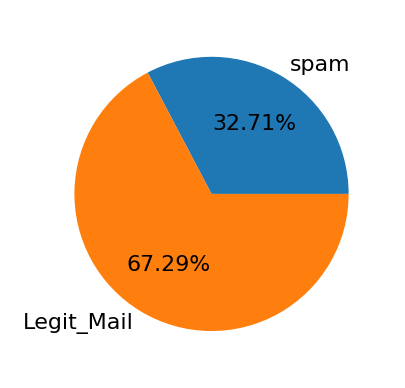

In [64]:
category_names=['spam' , 'Legit_Mail']
sizes=[amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize': 7},autopct='%1.2f%%')
plt.show()

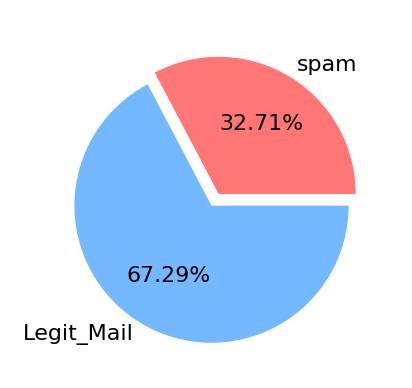

In [69]:
category_names=['spam' , 'Legit_Mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colours=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize': 7},autopct='%1.2f%%'
       ,colors=custom_colours, explode=[0,0.1])
plt.show()

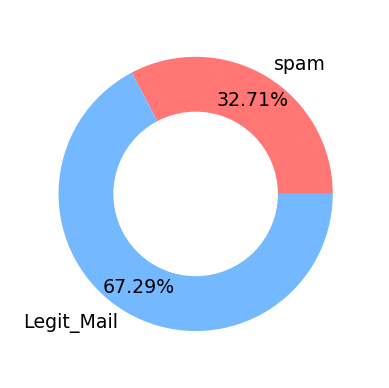

In [76]:
category_names=['spam' , 'Legit_Mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colours=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize': 6},autopct='%1.2f%%'
       ,colors=custom_colours,pctdistance=0.8)

#draw circle
centre_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# INTRODUCTION TO NATURAL LANGUAGE PROCESSING

## Text Pre_Processing

In [78]:
#convert to lower case
msg='ALL work ANd no Play makes Jack a dull Boy'
msg.lower()

'all work and no play makes jack a dull boy'

### DOWNLOAD NLTK

In [81]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### TOKENISING

In [86]:
#splits up all the words in a list of strings
msg='ALL work ANd no Play makes Jack a dull Boy'
msg.lower()
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

### Removing stopwords

In [89]:
stop_words=set(stopwords.words('english'))

In [90]:
type(stop_words)

set

In [91]:
if 'this' in stop_words: print('yaayyyy found it!!')

yaayyyy found it!!


In [93]:
if 'hello' not in stop_words: print('Ooops, not here!!')

Ooops, not here!!


In [96]:
msg='ALL work ANd no Play makes Jack a dull Boy. To be or not to be.'
words=word_tokenize(msg.lower())

filtered_words=[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### word stems and stemming

In [101]:
msg='ALL work ANd no Play makes Jack a dull Boy. \
To be or not to be. Nobody expects the spanish Inquisition!'
words=word_tokenize(msg.lower())
stemmer=PorterStemmer()

filtered_words=[]
for word in words:
    if word not in stop_words:
        
        stemmed_word= stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuations

In [103]:
msg='ALL work ANd no Play makes Jack a dull Boy. \
To be or not to be??? Nobody expects the spanish Inquisition!'
words=word_tokenize(msg.lower())
stemmer=PorterStemmer()
filtered_words=[]
for word in words:
    if word not in stop_words and word.isalpha():
        
        stemmed_word= stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [104]:
'p'.isalpha() #checks whether the given word is a string or a punctuation

True

###  Removing HTML Tags

In [117]:
Pos=2
label='MESSAGE'
data.at[Pos,label]
type(data)
soup=BeautifulSoup(data.at[2,'MESSAGE'],'html.parser')

ValueError: At based indexing on an non-integer index can only have non-integer indexers

## Functions for Email Processing 

In [155]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [156]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [157]:
#also remove HTML tags
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word) 
    
    return filtered_words

In [164]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

ValueError: At based indexing on an non-integer index can only have non-integer indexers

# Apply cleaning and tokenisation to all emails

### SLICING DataFrames and Series & Creating Subsets

In [178]:
data.iat[2,1]

1

In [179]:
data.iloc[0:5]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [180]:
first_emails=data.MESSAGE.iloc[0:3]
#data.MESSAGE.iloc[0:3]
nested_list=first_emails.apply(clean_message)

In [181]:
flat_list=[]
for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
        
        
len(flat_list)

321

In [182]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [183]:
nested_list= data.MESSAGE.apply(clean_msg_no_html)

In [184]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [185]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using Logic to Slice DATAFRAMES

In [186]:
data[data.CATEGORY==1].shape

(1896, 3)

In [187]:
doc_ids_ham= data[data.CATEGORY==0].index
doc_ids_spam= data[data.CATEGORY==1].index

In [188]:
doc_ids_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

In [189]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [190]:
nested_list_ham= nested_list.loc[doc_ids_ham]

In [191]:
nested_list_ham.shape

(3900,)

In [192]:
nested_list_spam= nested_list.loc[doc_ids_spam]

In [198]:
flat_list_ham= [item for sublist in nested_list_ham for item in sublist]
normal_words=pd.Series(flat_list_ham).value_counts()

In [200]:
normal_words.shape[0]

20755

In [202]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [203]:
flat_list_spam= [item for sublist in nested_list_spam for item in sublist]
spam_words=pd.Series(flat_list_spam).value_counts()

In [204]:
spam_words.shape[0]

13284

In [205]:
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Generate Vocabulary

In [206]:
stemmed_nested_list= data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]

In [208]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print('no. of unique words', unique_words.shape[0])
unique_words[:10]

no. of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64

In [210]:
freq= unique_words[0:2500]
print('Most common words are : ', freq[:10])

Most common words are :  http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Creating word ID for words

In [218]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': freq.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [220]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name,header = vocab.VOCAB_WORD.name)

## Check longest Email

In [222]:
clean_email_length=[]
for sublist in stemmed_nested_list:
    clean_email_length.append(len(sublist))

In [224]:
print(clean_email_length)

[92, 56, 44, 205, 45, 161, 47, 162, 202, 43, 55, 23, 44, 73, 58, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 24, 61, 94, 312, 56, 141, 72, 55, 1060, 46, 139, 2, 90, 78, 4, 47, 70, 44, 74, 38, 12, 38, 60, 47, 51, 71, 80, 25, 273, 36, 60, 19, 18, 14, 40, 57, 18, 77, 28, 102, 40, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 58, 253, 1216, 49, 0, 65, 52, 141, 15, 0, 90, 70, 2, 196, 50, 50, 50, 213, 117, 43, 80, 43, 319, 242, 9, 36, 97, 25, 52, 333, 47, 60, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 24, 129, 50, 0, 39, 74, 43, 72, 47, 157, 0, 27, 223, 97, 0, 58, 84, 213, 75, 47, 18, 166, 20, 112, 104, 187, 6, 40, 54, 79, 276, 110, 208, 6, 479, 62, 17, 175, 79, 47, 74, 80, 258, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1389, 108, 97, 23, 185, 1, 117, 258, 28, 142, 195, 177, 0, 97, 109, 1465, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 185, 77, 330, 14, 92, 92, 166, 372, 187, 241, 143, 254, 14, 97, 135, 223, 65, 90, 226, 217, 129, 38, 94, 204, 258, 215, 146

In [226]:
print(max(clean_email_length)) #longest email has this many words

7671


In [230]:
np.argmax(clean_email_length) #postion of the longest email

5775

## Creating a dataframe with one word in each coloumn

In [231]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [233]:
word_columns_df.shape

(5796, 7671)

## Splittin the Data into Training and Test sets

In [235]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [236]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [237]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [239]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [240]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [241]:
word_index.get_loc('jul')

494

In [242]:
def make_sparse_matrix(df, indexed_words, labels):
   
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [243]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [244]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,266
1,0,4844,1,1259
2,0,4844,1,509
3,0,4844,1,310
4,0,4844,1,254


In [245]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
430978,1,860,1,47
430979,1,860,1,1438
430980,1,860,1,26
430981,1,860,1,19
430982,1,860,1,126


## Combine Occurances with the Panda groupby()

In [246]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [247]:
vocab.at[1234,'VOCAB_WORD']

'physic'

In [248]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [249]:
train_grouped.shape

(258333, 4)

## Saving Training Data

In [252]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [253]:
X_test.shape

(1739, 7671)

In [254]:
spare_test_df= make_sparse_matrix(X_test,word_index,y_test)

In [255]:
spare_test_df.shape

(203150, 4)

In [257]:
test_grouped = spare_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [259]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Checking my understanding

In [260]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [261]:
len(test_doc_ids)

1724

In [262]:
len(X_test)

1739

In [263]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [267]:
data.MESSAGE[1700]

'------=_NextPart_000_00A2_25A50A3E.D1003C25\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPEhUTUw+DQo8SEVBRD4NCiAgIA0KICAgPFRJVExFPk1hcnJpZWQgQnV0IExv\n\nbmVseTwvVElUTEU+DQo8L0hFQUQ+DQo8Qk9EWSBCR0NPTE9SPSIjRkZGRkZG\n\nIiBMSU5LPSIjRkYwMDAwIiBWTElOSz0iI0ZGMDAwMCIgQUxJTks9IiNGRjAw\n\nMDAiPg0KDQo8UCBBTElHTj0iY2VudGVyIj4gPElNRyBCT1JERVI9IjAiIFNS\n\nQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3JnL3VzZXJzL3h4eGRhdGluZy9t\n\nYXJyaWVkYW5kbG9uZWx5L2ltYWdlcy9sb2dvLmpwZyIgV0lEVEg9IjUwMCIg\n\nSEVJR0hUPSIxOTEiPiZuYnNwOyAmbmJzcDsgPC9QPg0KPENFTlRFUj4NCiAg\n\nPFRBQkxFIENFTExTUEFDSU5HPTUgQ0VMTFBBRERJTkc9NSBCR0NPTE9SPSIj\n\nNjY2Njk5IiA+DQogICAgPFRSPg0KPFREPjxJTUcgU1JDPSJodHRwOi8vd3d3\n\nLnBhZ2U0bGlmZS5vcmcvdXNlcnMveHh4ZGF0aW5nL21hcnJpZWRhbmRsb25l\n\nbHkvcDcwNi5qcGciIEJPUkRFUj0wIEhFSUdIVD0xODAgV0lEVEg9MTIwPjwv\n\nVEQ+DQoNCjxURD48SU1HIFNSQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3Jn\n\nL3VzZXJzL3h4eGRhdGluZy9tYXJyaWVkYW5kbG9uZWx5L3A3MDQuanBnIiBC\n\nT1JERVI9MCBIRUlHSFQ9MTgwIF